# Other scaling
> Effect of number of samples, max depth, number of trees, and number of dimensions on runtime

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from hyperdt.forest import HyperbolicRandomForestClassifier
from hyperdt.toy_data import wrapped_normal_mixture

In [21]:
# Global hyperparams
N_DIM = 2
N_CLASSES = 10
N_SAMPLES = 5000
MAX_DEPTH = 3
N_TREES = 12
N_TRIALS = 5
TEST_SIZE = 0.2

# ==== IMPORTANT =====
FORCE_RETRAIN = True

  0%|          | 0/245 [00:00<?, ?it/s]

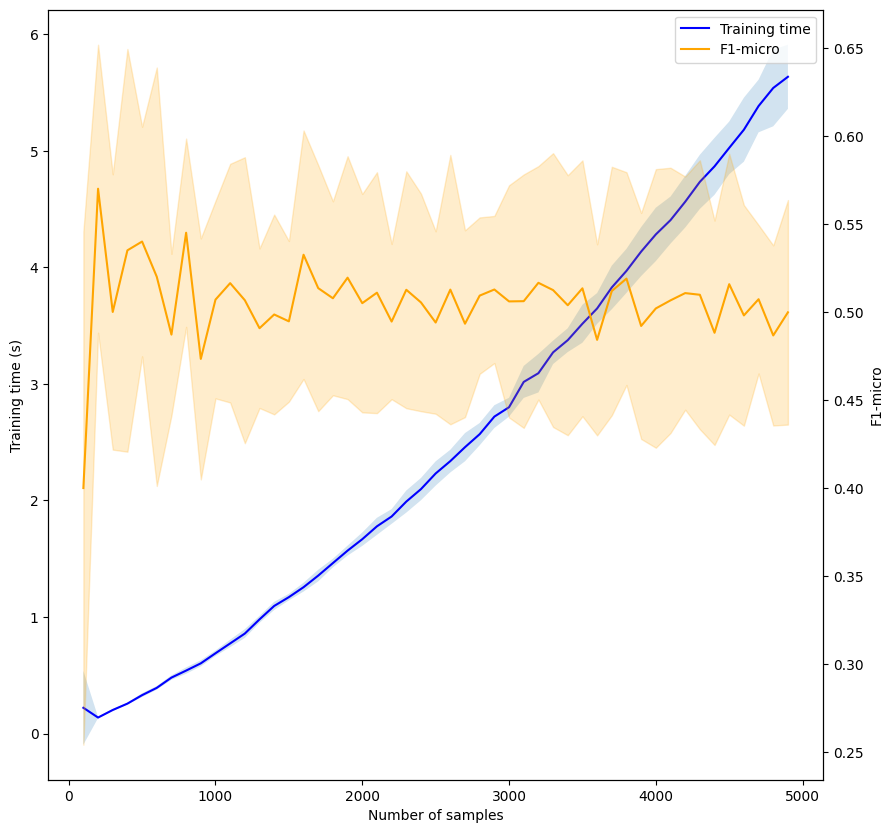

In [22]:
# Experiment 1: #samples

# Hyperparams
MIN_SAMPLES = 100
MAX_SAMPLES = 5000
STEP = 100

# Generate loop
if os.path.exists("../data/processed/supplement_benchmarks/n_samples_results.csv") and not FORCE_RETRAIN:
    n_samples_results = pd.read_csv("../data/processed/supplement_benchmarks/n_samples_results.csv")

else:
    n_samples_results = pd.DataFrame(columns=["n_samples", "trial", "time", "f1-micro"])
    sample_nums = range(MIN_SAMPLES, MAX_SAMPLES, STEP)
    my_tqdm = tqdm(total=len(sample_nums) * N_TRIALS)
    for n in sample_nums:
        for trial in range(N_TRIALS):
            X, y = wrapped_normal_mixture(num_points=n, num_classes=N_CLASSES, n_dim=N_DIM, seed=trial)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=trial)
            t1 = time()
            clf = HyperbolicRandomForestClassifier(n_estimators=N_TREES, max_depth=MAX_DEPTH, random_state=trial)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            t2 = time()
            n_samples_results.loc[len(n_samples_results)] = {
                "n_samples": n,
                "trial": trial,
                "time": t2 - t1,
                "f1-micro": f1_score(y_test, y_pred, average="micro"),
            }
            my_tqdm.update(1)
    n_samples_results.to_csv("../data/processed/supplement_benchmarks/n_samples_results.csv", index=False)

# Plotting
fig = plt.figure(figsize=(10, 10))
means = n_samples_results.groupby("n_samples").mean().reset_index()
stds = n_samples_results.groupby("n_samples").std().reset_index()

plt.plot(means["n_samples"], means["time"], color="blue", label="Training time")
plt.fill_between(means["n_samples"], means["time"] - stds["time"], means["time"] + stds["time"], alpha=0.2)
plt.xlabel("Number of samples")
plt.ylabel("Training time (s)")
h1, l1 = plt.gca().get_legend_handles_labels()

plt.twinx()

plt.plot(means["n_samples"], means["f1-micro"], color="orange", label="F1-micro")
plt.fill_between(
    means["n_samples"],
    means["f1-micro"] - stds["f1-micro"],
    means["f1-micro"] + stds["f1-micro"],
    color="orange",
    alpha=0.2,
)
plt.ylabel("F1-micro")
h2, l2 = plt.gca().get_legend_handles_labels()

plt.legend(h1 + h2, l1 + l2)
plt.show()

  0%|          | 0/75 [00:00<?, ?it/s]

Failed trial 2 for 20 dimensions
Failed trial 1 for 26 dimensions
Failed trial 0 for 28 dimensions
Failed trial 2 for 28 dimensions
Failed trial 3 for 28 dimensions
Failed trial 4 for 28 dimensions
Failed trial 0 for 30 dimensions
Failed trial 2 for 30 dimensions
Failed trial 3 for 30 dimensions
Failed trial 4 for 30 dimensions


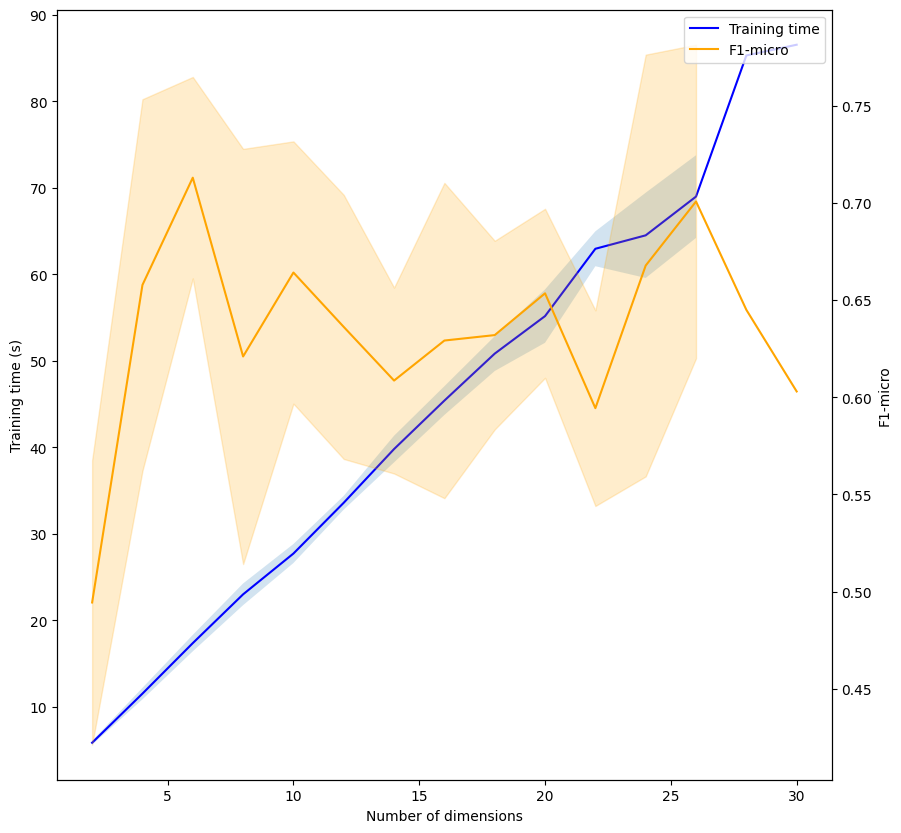

In [23]:
# Experiment 2: #dimensions

# Hyperparams
MIN_DIMS = 2
MAX_DIMS = 32
STEP = 2

# Generate loop
if os.path.exists("../data/processed/supplement_benchmarks/n_dims_results.csv") and not FORCE_RETRAIN:
    n_dims_results = pd.read_csv("../data/processed/supplement_benchmarks/n_dims_results.csv")

else:
    n_dims_results = pd.DataFrame(columns=["n_dims", "trial", "time", "f1-micro"])
    dims = range(MIN_DIMS, MAX_DIMS, STEP)
    my_tqdm = tqdm(total=len(dims) * N_TRIALS)
    for d in dims:
        for trial in range(N_TRIALS):
            X, y = wrapped_normal_mixture(num_points=N_SAMPLES, num_classes=N_CLASSES, n_dim=d, seed=trial)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=trial)
            t1 = time()
            try:
                clf = HyperbolicRandomForestClassifier(n_estimators=N_TREES, max_depth=MAX_DEPTH, random_state=trial)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                t2 = time()
                n_dims_results.loc[len(n_dims_results)] = {
                    "n_dims": d,
                    "trial": trial,
                    "time": t2 - t1,
                    "f1-micro": f1_score(y_test, y_pred, average="micro"),
                }
            except:
                print(f"Failed trial {trial} for {d} dimensions")
            my_tqdm.update(1)
    n_dims_results.to_csv("../data/processed/supplement_benchmarks/n_dims_results.csv", index=False)

# Plotting
fig = plt.figure(figsize=(10, 10))
means = n_dims_results.groupby("n_dims").mean().reset_index()
stds = n_dims_results.groupby("n_dims").std().reset_index()

plt.plot(means["n_dims"], means["time"], color="blue", label="Training time")
plt.fill_between(means["n_dims"], means["time"] - stds["time"], means["time"] + stds["time"], alpha=0.2)
plt.xlabel("Number of dimensions")
plt.ylabel("Training time (s)")
h1, l1 = plt.gca().get_legend_handles_labels()

plt.twinx()

plt.plot(means["n_dims"], means["f1-micro"], color="orange", label="F1-micro")
plt.fill_between(
    means["n_dims"],
    means["f1-micro"] - stds["f1-micro"],
    means["f1-micro"] + stds["f1-micro"],
    color="orange",
    alpha=0.2,
)
plt.ylabel("F1-micro")
h2, l2 = plt.gca().get_legend_handles_labels()

plt.legend(h1 + h2, l1 + l2)
plt.show()

In [24]:
# Experiment 3: number of trees

# Hyperparams
MIN_TREES = 10
MAX_TREES = 100
STEP = 10

# Generate loop
if os.path.exists("../data/processed/supplement_benchmarks/n_trees_results.csv") and not FORCE_RETRAIN:
    n_trees_results = pd.read_csv("../data/processed/supplement_benchmarks/n_trees_results.csv")

else:
    n_trees_results = pd.DataFrame(columns=["n_trees", "trial", "time", "f1-micro"])
    trees = range(MIN_TREES, MAX_TREES, STEP)
    my_tqdm = tqdm(total=len(trees) * N_TRIALS)
    for n_trees in trees:
        for trial in range(N_TRIALS):
            X, y = wrapped_normal_mixture(num_points=N_SAMPLES, num_classes=N_CLASSES, n_dim=N_DIM, seed=trial)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=trial)
            t1 = time()
            try:
                clf = HyperbolicRandomForestClassifier(n_estimators=n_trees, max_depth=MAX_DEPTH, random_state=trial)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                t2 = time()
                n_trees_results.loc[len(n_trees_results)] = {
                    "n_trees": n_trees,
                    "trial": trial,
                    "time": t2 - t1,
                    "f1-micro": f1_score(y_test, y_pred, average="micro"),
                }
            except:
                print(f"Failed trial {trial} for {d} dimensions")
            my_tqdm.update(1)
    n_trees_results.to_csv("../data/processed/supplement_benchmarks/n_trees_results.csv", index=False)

# Plotting
fig = plt.figure(figsize=(10, 10))
means = n_trees_results.groupby("n_trees").mean().reset_index()
stds = n_trees_results.groupby("n_trees").std().reset_index()

plt.plot(means["n_trees"], means["time"], color="blue", label="Training time")
plt.fill_between(means["n_trees"], means["time"] - stds["time"], means["time"] + stds["time"], alpha=0.2)
plt.xlabel("Number of trees")
plt.ylabel("Training time (s)")
h1, l1 = plt.gca().get_legend_handles_labels()

plt.twinx()

plt.plot(means["n_trees"], means["f1-micro"], color="orange", label="F1-micro")
plt.fill_between(
    means["n_trees"],
    means["f1-micro"] - stds["f1-micro"],
    means["f1-micro"] + stds["f1-micro"],
    color="orange",
    alpha=0.2,
)
plt.ylabel("F1-micro")
h2, l2 = plt.gca().get_legend_handles_labels()

plt.legend(h1 + h2, l1 + l2)
plt.show()

  0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
# Experiment 4: max depth

# Hyperparams
MIN_DEPTH = 1
MAX_DEPTH = 12
STEP = 1

# Generate loop
if os.path.exists("../data/processed/supplement_benchmarks/max_depth_results.csv") and not FORCE_RETRAIN:
    max_depth_results = pd.read_csv("../data/processed/supplement_benchmarks/max_depth_results.csv")

else:
    max_depth_results = pd.DataFrame(columns=["max_depth", "trial", "time", "f1-micro"])
    depths = range(MIN_DEPTH, MAX_DEPTH, STEP)
    my_tqdm = tqdm(total=len(depths) * N_TRIALS)
    for max_depth in depths:
        for trial in range(N_TRIALS):
            X, y = wrapped_normal_mixture(num_points=N_POINTS, num_classes=N_CLASSES, n_dim=N_DIM, seed=trial)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial)
            t1 = time()
            try:
                clf = HyperbolicRandomForestClassifier(n_estimators=N_TREES, max_depth=max_depth, random_state=trial)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                t2 = time()
                max_depth_results.loc[len(max_depth_results)] = {
                    "max_depth": max_depth,
                    "trial": trial,
                    "time": t2 - t1,
                    "f1-micro": f1_score(y_test, y_pred, average="micro"),
                }
            except:
                print(f"Failed trial {trial} for {d} dimensions")
            my_tqdm.update(1)
    max_depth_results.to_csv("../data/processed/supplement_benchmarks/max_depth_results.csv", index=False)

# Plotting
fig = plt.figure(figsize=(10, 10))
means = max_depth_results.groupby("max_depth").mean().reset_index()
stds = max_depth_results.groupby("max_depth").std().reset_index()

plt.plot(means["max_depth"], means["time"], color="blue", label="Training time")
plt.fill_between(means["max_depth"], means["time"] - stds["time"], means["time"] + stds["time"], alpha=0.2)
plt.xlabel("Max depth")
plt.ylabel("Training time (s)")
h1, l1 = plt.gca().get_legend_handles_labels()

plt.twinx()

plt.plot(means["max_depth"], means["f1-micro"], color="orange", label="F1-micro")
plt.fill_between(
    means["max_depth"],
    means["f1-micro"] - stds["f1-micro"],
    means["f1-micro"] + stds["f1-micro"],
    color="orange",
    alpha=0.2,
)
plt.ylabel("F1-micro")
h2, l2 = plt.gca().get_legend_handles_labels()

plt.legend(h1 + h2, l1 + l2)
plt.show()